---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [1]:
import pandas as pd
import numpy as np
import re

from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less affected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [2]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [3]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )

    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    region = pd.read_table('university_towns.txt', names=['RegionName'], squeeze=True)    
    state = pd.Series(np.where(region.str.contains('\[edit\]'), region, np.nan))

    ul = pd.concat([state, region], axis=1)
    ul.columns = ['State', 'RegionName']
    
    # Missing values
    ul['State'].fillna(method='ffill', inplace=True)
    ul = ul[ul['State'] != ul['RegionName']]
    
    # Clean
    ul.replace(to_replace=r"(\[| \().*$", value="", regex=True, inplace=True)
    
    return ul

get_list_of_university_towns().head()

,State,RegionName
1,Alabama,Auburn
2,Alabama,Florence
3,Alabama,Jacksonville
4,Alabama,Livingston
5,Alabama,Montevallo


In [4]:
def get_gdp_data():
    gdp = pd.read_excel("gdplev.xls", skiprows=219, parse_cols='E, G', names=['Quarter', 'GDP'])
    return gdp

get_gdp_data().head()

,Quarter,GDP
0,2000q1,12359.1
1,2000q2,12592.5
2,2000q3,12607.7
3,2000q4,12679.3
4,2001q1,12643.3


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


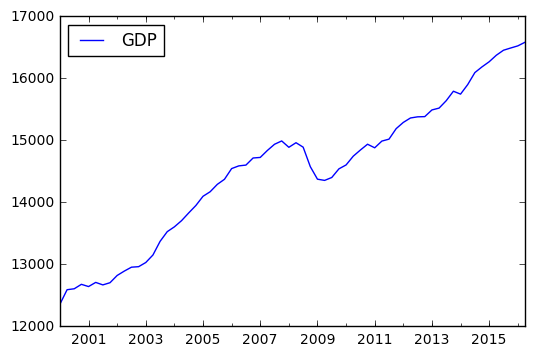

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
get_gdp_data().set_index(pd.period_range(start='2000Q1', end='2016Q2', freq='Q')).plot()

In [6]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    
    gdp = get_gdp_data()
    gdp['inc'] = gdp['GDP'].diff() >= 0
    
    # find the decreasing sequence
    dec = gdp.groupby('inc').groups[False]
    cum = [0] * len(dec)

    for i in range(len(dec)-1, 0, -1):
        if dec[i-1] == dec[i] - 1:
            cum[i-1] = cum[i] + 1
     
    start = pd.Series(cum).idxmax()
        
    return gdp['Quarter'].iloc[dec[start]]

get_recession_start()

'2008q3'

In [7]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
       
    gdp = get_gdp_data()
    gdp['inc'] = gdp['GDP'].diff() >= 0
    
    start = gdp[gdp['Quarter'] == get_recession_start()].index[0]
    
    # return the 2nd subsequent increasing quarter after the recession start
    inc = gdp[start:].groupby('inc').groups[True]

    for i in range(len(inc) - 1):
        if inc[i] == inc[i+1] - 1:
            return gdp['Quarter'].iloc[inc[i+1]]
    
get_recession_end()

'2009q4'

In [8]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    
    start = get_recession_start()
    end = get_recession_end()
    
    gdp = get_gdp_data().set_index('Quarter')
    
    return gdp[start:end].idxmin()[0]

get_recession_bottom()

'2009q2'

In [9]:
def get_housing_data():
    cols = list(range(1, 3)) + list(range(51, 251))
    hd = pd.read_csv('City_Zhvi_AllHomes.csv', usecols=cols)
    hd['State'].replace(states, inplace=True)

    return hd

get_housing_data().head()

,RegionName,State,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,Los Angeles,California,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,Chicago,Illinois,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,Philadelphia,Pennsylvania,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,Phoenix,Arizona,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [10]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    hd = get_housing_data()

    hd.set_index(['State', 'RegionName'], inplace=True)
    
    # Resample months to quarters
    hdT = hd.T.set_index(pd.to_datetime(hd.T.index).to_period())
    hdT = hdT.resample('Q').mean()
        
    return hdT.T
    
convert_housing_data_to_quarters().head()

,,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [11]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    ul = get_list_of_university_towns().set_index(['State', 'RegionName'])
    hd = convert_housing_data_to_quarters()
    
    hd = hd.loc[hd.index, pd.period_range(start=get_recession_start(), end=get_recession_end(), freq='Q')]
    #print(hd.mean())
    
    diffSeries = hd['2009Q4'] - hd['2008Q3']

    diffU = diffSeries.loc[ul.index]
    mask = diffSeries.index.isin(ul.index)
    diffNU = diffSeries.loc[~mask]
    
    s, p = ttest_ind(diffU.dropna(), diffNU.dropna())
    
    return (p < 0.01, p, "university town")

run_ttest()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.


(True, 0.0014601500240342151, 'university town')